# Imports

In [1]:
import os
import imageio
from glob import glob
from PIL import Image
from IPython import display

import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt

# Constants

In [2]:
BATCH_SIZE = 128
LATENT_DIM = 100
SAMPLE_INTERVAL = 200
EPOCHS = 10000

# Utility Functions

In [3]:
def generate_gif(gif_name='mnist_gan.gif', pattern='image*.png'):
    with imageio.get_writer(gif_name, mode='I') as writer:
        filenames = glob(pattern)
        filenames = sorted(filenames)
        last = -1
        for i,filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
            
        image = imageio.imread(filename)
        writer.append_data(image)

    os.system('cp {} {}.png'.format(gif_name, gif_name))

In [4]:
def sample_images(generator, epoch, save=True, name='mnist'):
    noise = np.random.normal(size=(5 * 5, LATENT_DIM))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5     # Rescale images 0-1

    fig, axs = plt.subplots(5, 5)
    c = 0
    for i in range(5):
        for j in range(5):
            axs[i,j].imshow(gen_imgs[c, :, :, 0], cmap='gray')
            axs[i,j].axis('off')
            c += 1
            
    if save:
        fig.savefig("{}_{}.png".format(name, epoch))
        plt.close()
    else:
        plt.show()

# Training to generate MNIST dataset

In [5]:
(X, _), (_, _) = keras.datasets.mnist.load_data()

X = X.reshape(X.shape[0], 28, 28, 1).astype('float32')
X = (X - 127.5) / 127.5

# Generator Architecture

In [6]:
def build_generator(output_shape=(28, 28, 1)): 
    model = keras.Sequential(name='generator')
    
    model.add(keras.layers.Dense(256, input_shape=(LATENT_DIM, )))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.BatchNormalization(momentum=0.8))

    model.add(keras.layers.Dense(512))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.BatchNormalization(momentum=0.8))

    model.add(keras.layers.Dense(1024))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.BatchNormalization(momentum=0.8))

    model.add(keras.layers.Dense(np.prod(output_shape), activation='tanh'))
    model.add(keras.layers.Reshape(output_shape))

    return model

In [7]:
build_generator().summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 512)               2048      
_________________________________________________________________
dens

# Discriminator Architecture

In [8]:
def build_discriminator(input_shape=(28, 28, 1)):
    model = keras.Sequential(name='discriminator')

    model.add(keras.layers.Flatten(input_shape=input_shape))
    model.add(keras.layers.Dense(512))
    model.add(keras.layers.LeakyReLU(alpha=0.2))

    model.add(keras.layers.Dense(256))
    model.add(keras.layers.LeakyReLU(alpha=0.2))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    return model

In [9]:
build_discriminator().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


# Compiling Models

In [10]:
optimizer = keras.optimizers.Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['acc'])
discriminator.trainable = False

latent_input = keras.Input(shape=(LATENT_DIM,)) 
generator = build_generator()
discriminator_output = discriminator(generator(latent_input))

combined_model = keras.Model(latent_input, discriminator_output)
combined_model.compile(loss='binary_crossentropy', optimizer=optimizer)
combined_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
generator (Sequential)       (None, 28, 28, 1)         1493520   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [11]:
real_data_labels = np.ones((BATCH_SIZE, 1))
gen_data_labels = np.zeros((BATCH_SIZE, 1))

discriminator_real_loss, discriminator_real_acc = [], []
discriminator_fake_loss, discriminator_fake_acc = [], []

generator_loss = []

for epoch in range(EPOCHS):
    # (128, 28, 28, 1) (Generator noise)
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))

    # X (60000, 28, 28, 1) (Fetching random samples from real images)
    # imgs (128, 28, 28, 1) 
    imgs = X[np.random.randint(0, X.shape[0], BATCH_SIZE)] 

    # (loss, acc)                      (128, 28, 28, 1)  (128,)    
    disc_loss_real = discriminator.train_on_batch(imgs, real_data_labels)
    
    # (loss, acc)                                 (128, 28, 28, 1)            (128,)
    disc_loss_fake = discriminator.train_on_batch(generator.predict(noise), gen_data_labels)

    # (128, 100)
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))
    gen_loss = combined_model.train_on_batch(noise, real_data_labels)
    #                                    (128, 100)  (128,)

    # averaging result of discriminator
    disc_loss, disc_acc = 0.5 * np.add(disc_loss_real, disc_loss_fake)
    
    display.clear_output(wait=True)
    print ("Epoch : %d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, disc_loss, 100*disc_acc, gen_loss))

    discriminator_real_loss.append(disc_loss_real[0])
    discriminator_real_acc.append(disc_loss_real[1])
    
    discriminator_fake_loss.append(disc_loss_fake[0])
    discriminator_fake_acc.append(disc_loss_fake[1])
    
    generator_loss.append(gen_loss)
    
    if epoch % SAMPLE_INTERVAL == 0:
        sample_images(generator, epoch, name='../working/mnist')

Epoch : 9999 [Discriminator loss: 0.685160, acc.: 58.59%] [Generator loss: 0.847148]


# Plotting Training

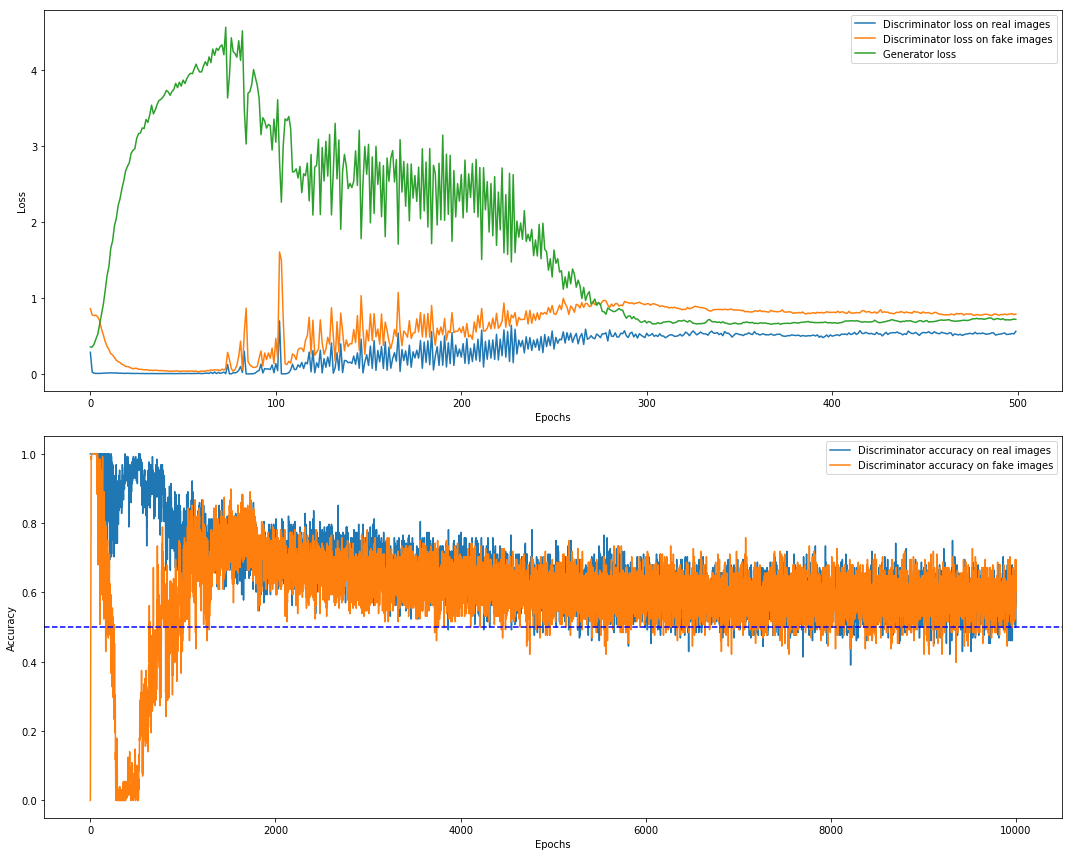

In [13]:
till = 500
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

ax[0].plot(discriminator_real_loss[:till], label="Discriminator loss on real images")
ax[0].plot(discriminator_fake_loss[:till], label="Discriminator loss on fake images")
ax[0].plot(generator_loss[:till], label="Generator loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(discriminator_real_acc, label="Discriminator accuracy on real images")
ax[1].plot(discriminator_fake_acc, label="Discriminator accuracy on fake images")
ax[1].axhline(y=0.5, color='blue', linestyle='--')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.tight_layout()
plt.show()

# Generated Images

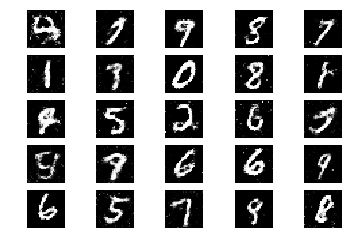

In [14]:
sample_images(generator, None, save=False)

# Training Deep Convolutional GAN on Fashion MNIST

In [15]:
(X, _), (_, _) = keras.datasets.fashion_mnist.load_data()

X = X.reshape(X.shape[0], 28, 28, 1).astype('float32')
X = (X - 127.5) / 127.5 # Normalize the images to [-1, 1]

# Generator Architecture

In [16]:
def generator_model():
    model = keras.Sequential()
    
    model.add(keras.layers.Dense(7 * 7 * 128, activation="relu", input_shape=(LATENT_DIM,)))
    model.add(keras.layers.Reshape((7, 7, 128)))
    
    model.add(keras.layers.UpSampling2D())
    model.add(keras.layers.Conv2D(128, (3, 3), padding='same'))
    model.add(keras.layers.BatchNormalization(momentum=0.8))
    model.add(keras.layers.ReLU())

    model.add(keras.layers.UpSampling2D())
    model.add(keras.layers.Conv2D(64, (3, 3), padding='same'))
    model.add(keras.layers.BatchNormalization(momentum=0.8))
    model.add(keras.layers.ReLU())

    model.add(keras.layers.Conv2D(1, (3, 3), padding='same', activation='tanh'))
  
    return model

In [17]:
generator_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 14, 14, 128)       512       
_________________________________________________________________
re_lu (ReLU)                 (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 128)       0         
__________

# Discriminator Architecture

In [18]:
def discriminator_model():
    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dropout(rate = 0.25))
      
    model.add(keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization(momentum=0.8))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dropout(rate = 0.25))
    
    model.add(keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization(momentum=0.8))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dropout(rate = 0.25))
    
    model.add(keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization(momentum=0.8))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dropout(rate = 0.25))
       
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation='sigmoid'))
     
    return model

In [19]:
discriminator_model().summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_v1_8 (Ba (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 7, 7, 64)          0         
___________________________

# Compiling Models

In [20]:
optimizer = keras.optimizers.Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,  metrics=['acc'])
discriminator.trainable = False

latent_input = keras.Input(shape=(LATENT_DIM,)) 
generator = build_generator()
discriminator_output = discriminator(generator(latent_input))

combined_model = keras.Model(latent_input, discriminator_output)
combined_model.compile(loss='binary_crossentropy', optimizer=optimizer)
combined_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
generator (Sequential)       (None, 28, 28, 1)         1493520   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [21]:
real_data_labels = np.ones((BATCH_SIZE, 1))
gen_data_labels = np.zeros((BATCH_SIZE, 1))

discriminator_real_loss, discriminator_real_acc = [], []
discriminator_fake_loss, discriminator_fake_acc = [], []

generator_loss = []

for epoch in range(EPOCHS):
    # (128, 28, 28, 1) (Generator noise)
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))

    # X (60000, 28, 28, 1) (Fetching random samples from real images)
    # imgs (128, 28, 28, 1) 
    imgs = X[np.random.randint(0, X.shape[0], BATCH_SIZE)] 

    # (loss, acc)                      (128, 28, 28, 1)  (128,)    
    disc_loss_real = discriminator.train_on_batch(imgs, real_data_labels)
    
    # (loss, acc)                                 (128, 28, 28, 1)            (128,)
    disc_loss_fake = discriminator.train_on_batch(generator.predict(noise), gen_data_labels)

    # (128, 100)
    noise = np.random.normal(size=(BATCH_SIZE, LATENT_DIM))
    gen_loss = combined_model.train_on_batch(noise, real_data_labels)
    #                                    (128, 100)  (128,)

    # averaging result of discriminator
    disc_loss, disc_acc = 0.5 * np.add(disc_loss_real, disc_loss_fake)
    
    display.clear_output(wait=True)
    print ("Epoch : %d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, disc_loss, 100*disc_acc, gen_loss))

    discriminator_real_loss.append(disc_loss_real[0])
    discriminator_real_acc.append(disc_loss_real[1])
    
    discriminator_fake_loss.append(disc_loss_fake[0])
    discriminator_fake_acc.append(disc_loss_fake[1])
    
    generator_loss.append(gen_loss)
    
    if epoch % SAMPLE_INTERVAL == 0:
        sample_images(generator, epoch, name='../working/mnist')

Epoch : 9999 [Discriminator loss: 0.688061, acc.: 53.91%] [Generator loss: 0.814087]


# Plotting Training

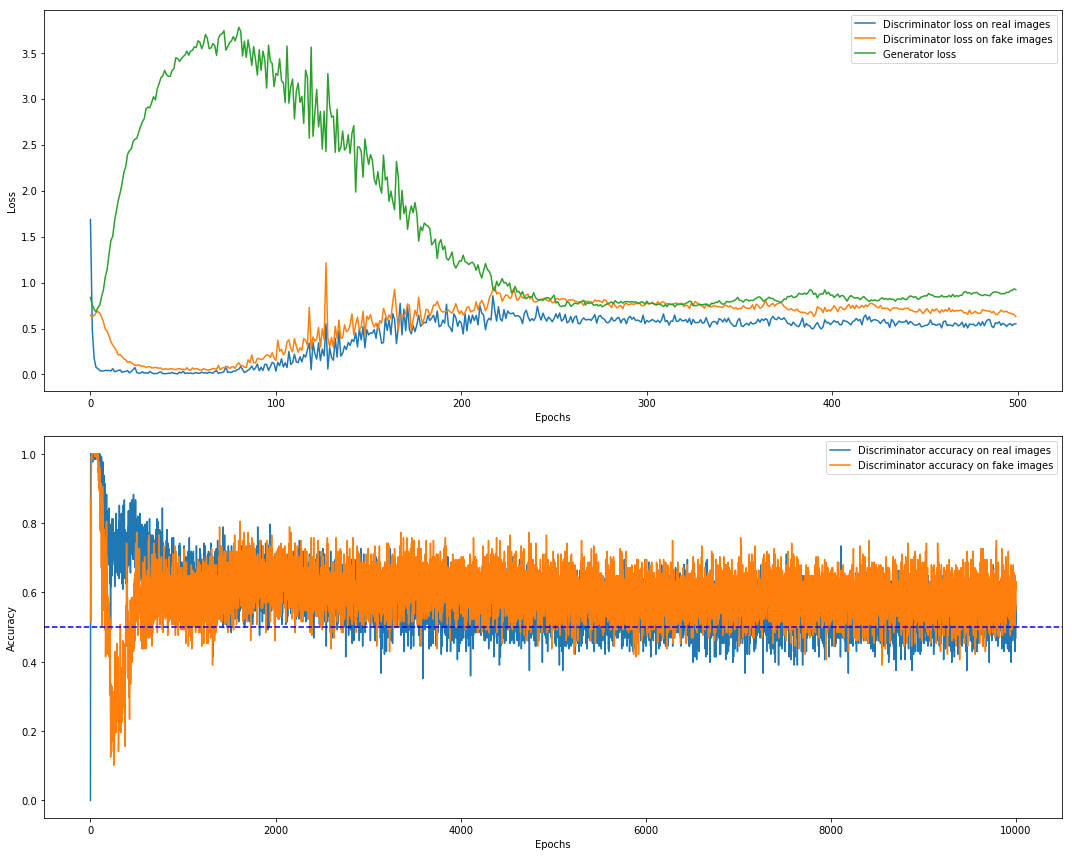

In [22]:
till = 500
fig, ax = plt.subplots(2, 1, figsize=(15, 12))

ax[0].plot(discriminator_real_loss[:till], label="Discriminator loss on real images")
ax[0].plot(discriminator_fake_loss[:till], label="Discriminator loss on fake images")
ax[0].plot(generator_loss[:till], label="Generator loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(discriminator_real_acc, label="Discriminator accuracy on real images")
ax[1].plot(discriminator_fake_acc, label="Discriminator accuracy on fake images")
ax[1].axhline(y=0.5, color='blue', linestyle='--')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.tight_layout()
plt.show()

# Generated Images

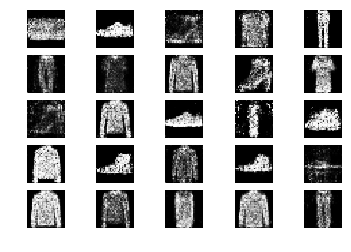

In [23]:
sample_images(generator, None, save=False, name='../working/fmnist')